# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_15_20.csv', encoding='latin-1')
raw_df = raw_df.dropna(how='all')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check size of the data set
raw_df.shape

(2618, 24)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2618, 4)

In [9]:
raw_df.head(11)

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0.0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1.0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1.0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0.0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0.0
5,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,Loan Default,0.0
6,20120828_01Y0R8_Prospectus_CM00000000205875087...,So long as no Trigger Period or Event of Defau...,Loan Default,0.0
7,20120828_01Y0R8_Prospectus_CM00000000205875087...,During the continuance of a Trigger Period or ...,Loan Default,0.0
8,20120828_01Y0R8_Prospectus_CM00000000205875087...,ÒTrigger PeriodÓ means any period that the deb...,DSCR Fall,0.0
9,20120828_01Y0R8_Prospectus_CM00000000205875087...,"During the continuance of a Trigger Period, th...",Loan Default,0.0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   496
Loan Default                  468
Debt Yield Fall               168
Loan default                   75
Tenant Failure                 74
Mezzanine Default              63
Bankruptcy                     47
Debt yield fall                34
DSCR Fall                      24
Renovations                    24
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      12
Mezzanine Outstanding          10
SFF                             9
Aggregate DSCR Fall             8
Mezzanine default               8
Aggregate debt yield fall       6
Delayed Repayment               3
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [13]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [14]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [15]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  543
Unspecified                   496
Debt Yield Fall               202
Tenant Failure                 74
Mezzanine Default              71
Bankruptcy                     47
Dscr Fall                      24
Renovations                    24
Operator Termination           19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

In [16]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [17]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)


In [18]:
raw_df.shape

(2618, 3)

In [19]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

35 unique documents have been included in the data set


In [20]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [21]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 35 Documents have tag counts that range from 25 to 176.


In [22]:
# Check for duplicate rows
#raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
#raw_df['is_duplicate'].value_counts()

In [23]:
#num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
#print(f'There are {num_duplicated_rows} row duplicates in the data set.')

In [24]:
# This removes duplicate rows, but those rows are in fact legitimate in the document
#raw_df = raw_df.drop('is_duplicate', axis = 1)
#raw_df = raw_df.drop_duplicates()

In [25]:
raw_df.shape

(2618, 3)

In [26]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [27]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  543
Unspecified                   496
Debt Yield Fall               202
Tenant Failure                 74
Mezzanine Default              71
Bankruptcy                     47
Dscr Fall                      24
Renovations                    24
Operator Termination           19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

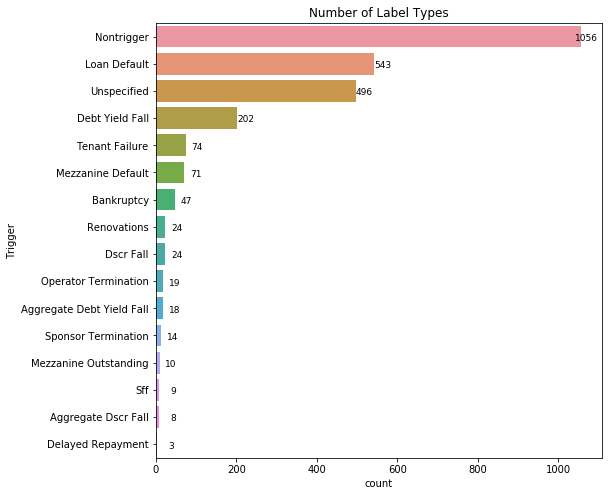

In [28]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Label Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [29]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [30]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [31]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
        
    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [32]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [33]:
df.shape

(2240, 18)

In [34]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
df.shape

(2240, 18)

In [36]:
# Export reshaped to CSV file
# df.to_csv('../data/reshaped_06_15_20_dedupe.csv')

In [37]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [38]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,sum
Document,,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,0,0,63.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,0,56.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,0,25.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,0,0,117.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,0,0,62.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,7,0,0,0,0,0,2,0,0,33,0,0,68.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,0,84.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,0,0,69.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,0,0,64.0


In [39]:
# Export reshaped to CSV file
# doc_view.to_csv('../data/exported_data/doc_view_06_15_20.csv')

In [40]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [41]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [42]:
df.shape

(2240, 18)

## Feature Engineering

In [43]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [44]:
print(f"Sentences range in length from {df['Sentence'].str.split().str.len().min()} to {df['Sentence'].str.split().str.len().max()} words.")
print(f"Sentences range in length from {df['Sentence'].str.len().min()} to {df['Sentence'].str.len().max()} characters.")


Sentences range in length from 2 to 1352 words.
Sentences range in length from 12 to 8292 characters.


In [45]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1767
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235


In [46]:
trigger_sentences_only = df.loc[df['nontrigger'] == 0]

In [47]:
trigger_sentences_only['sentence_char_count'].min()

34

In [48]:
trigger_sentences_only.loc[trigger_sentences_only['sentence_char_count'] == 34]

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,sentence_char_count
2194,20190829_02KYXE_Prospectus_SD00000000270246996...,ÒRequired Debt YieldÓ means 9.00%.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34


## Natural Language Processing of the sentence column

In [49]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [50]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [51]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [52]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [53]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')

In [54]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1767,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [55]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [56]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day the financial institution maintain the block account w'

In [57]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [58]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

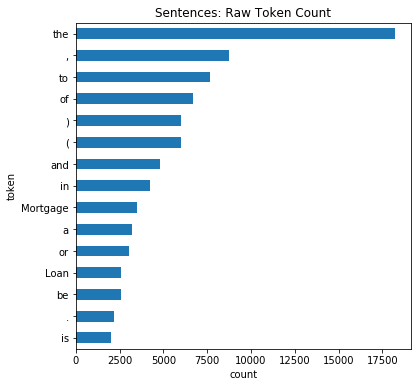

In [59]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

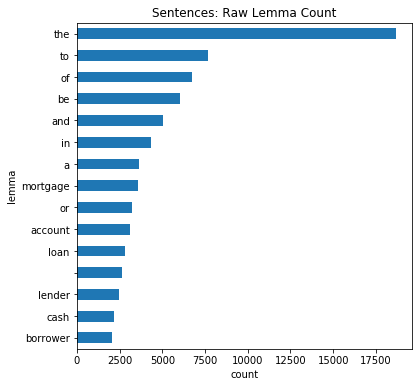

In [60]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [61]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [62]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

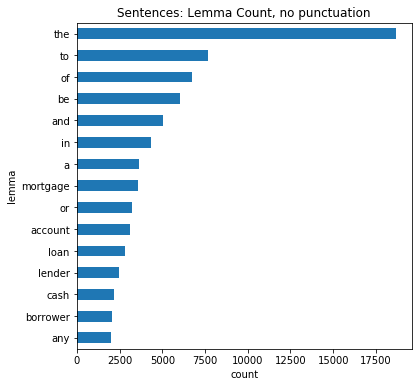

In [63]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [64]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [65]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [66]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [67]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a', 'marriott']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'marriott']

In [68]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords = stopwords + ['marriott']

## Train/Test Split

In [69]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...",on each business day the financial institution...,on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1767,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [70]:
# Start by predicting Loan Default trigger

target = 'nontrigger'


X = df['SentenceLemmas']
y = df[target]
indices = df.index

y = y.astype('int')

In [71]:
y.dtypes

dtype('int64')

In [72]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (2240,)
y shape is (2240,)


In [73]:
y.value_counts()

0    1210
1    1030
Name: nontrigger, dtype: int64

In [74]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(indices_train.shape, indices_test.shape)

(1568,) (1568,)
(672,) (672,)
(1568,) (672,)


In [75]:
X.head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas, dtype: object

In [76]:
X_train.shape[0]

1568

In [77]:
y_train.shape[0]

1568

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [78]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 279.974


In [79]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.992
Test score is 0.974
Cross Validation score is 0.929
Seconds elapsed for score calculation: 1.852


In [80]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.973
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': ['now', 'no', 'to', 'here', 'while', 'i', 'whoever', 'hereby', 'show', 'whereupon', 'five', 'her', 'herself', 'on', 'our', 'thru', 'whole', 'amount', 'beforehand', 'yet', 'part', 'somehow', 'any', 'above', 'an', 'everywhere', 'which', 'already', 'even', 'but', 'does', 'forty', 'some', 'upon', 'seeming', 'than', 'during', 'call', 'below', 'make', 'your', 'is', 'them', 'thereby', 'whereas', 'throughout', 'own', 'these', 'once', 'too', 'hence', 'still', 'then', 'give', 'side', 'eleven', 'must', 'always', 'next', 'sixty', 'third', 'hereupon', 'with', 'yourselves', 'in', 'although', 'anyway', 'thereupon', 'ca', 'behind', 'he', 'each', 'just', 'between', 'after', 'against', 'nowhere', 'this', 'very', 'mine', 'whereafter', 'his', 'thus', 'am', 'bottom', 'hundred', 'many', 'four', 'few', 'whenever', 'amongst', 'whose', 'indeed', 'hereafter', '

### 5: CountVectorizor + Random Forest

In [81]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

"\n# Define CVEC + Logistic Regression Pipeline\npipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])\nrf_params = {\n    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],\n    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  \n    'cvec__max_features': [100, 200, 400, 800],\n    'cvec__min_df': [2],\n    'cvec__max_df': [.99],\n    'rf__max_depth': [4,5, 6],\n    'rf__min_samples_split': [2,3],\n    'rf__min_samples_leaf': [10, 12]\n    }\n\ngs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')\n\n# Start the timer.\nt0 = time.time()\n\nresults_rf = gs_rf.fit(X_train, y_train)\n\nprint(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.\n\n"

In [82]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

"\nt0 = time.time()\nprint(f'Training score is {results_rf.score(X_train, y_train):.3f}')\nprint(f'Test score is {results_rf.score(X_test, y_test):.3f}')\nprint(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')\nprint(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.\n"

In [83]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

"\nprint(f'Best Score: {results_rf.best_score_}')\nprint(f'Best Parameters: {results_rf.best_params_}')\n"

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [84]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.540
CountVectorizer + LogisticRegression Accuracy: 0.992


In [85]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.540
CountVectorizer + LogisticRegression Accuracy: 0.974


## Model Evaluation - Logistic Regression

In [86]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [87]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.1256277410922729,
 0.15371395457613438,
 0.1278904858661776,
 0.07956841945620649,
 0.22656447390221868,
 0.2725822257061773,
 0.08541634256303424,
 0.13674793607952251,
 0.09968621194243282,
 0.1615824961106216]

In [88]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [89]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [90]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
305,description,1.083702
626,net,0.708544
456,income,0.551991
870,security,0.533955
560,management,0.533126
586,mezzanine loan event default,0.520576
585,mezzanine loan event,0.520576
229,credit,0.501690
317,disburse accordance,0.493057
928,tax account,0.491028


In [91]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
963,trigger,-2.587379
700,period,-2.059330
170,cash management period,-1.704009
262,default,-1.648426
345,event,-1.557281
965,trigger period,-1.496652
155,cash,-1.319094
347,event default,-1.315464
919,sweep,-1.269138
701,period borrower,-0.978955


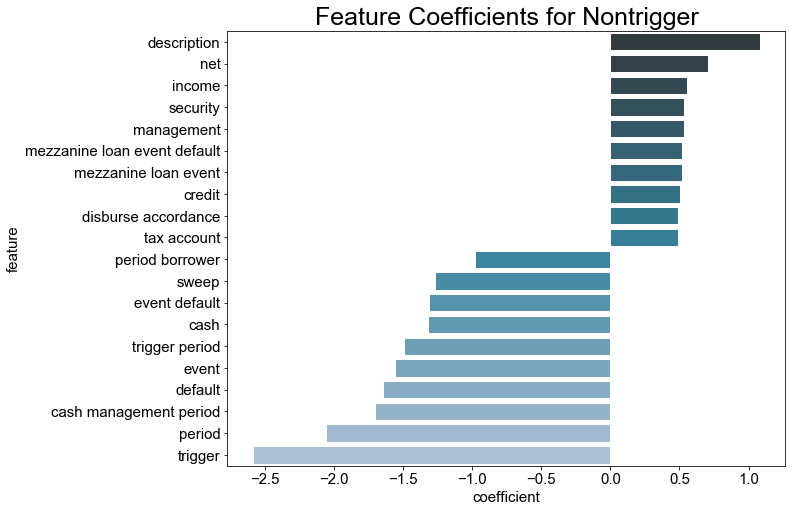

In [92]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [93]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [94]:
# Checking our predictions
preds[:10]

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [95]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[356   7]
 [  9 300]]


In [96]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [97]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,356,7
Actual Positive,9,300


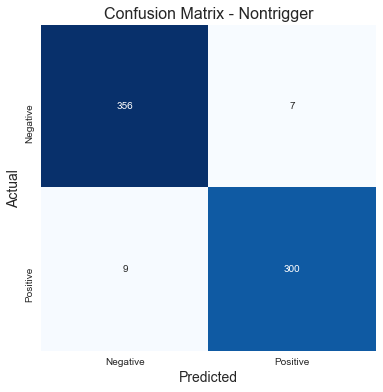

In [98]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title(f'Confusion Matrix - {target.replace("_", " ").title()}', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [99]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)



In [100]:
# Calculate probabilities
pred_proba = [i[1] for i in results_cvec.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.shape

(672, 2)

In [101]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = results_cvec.predict_proba(X_test)

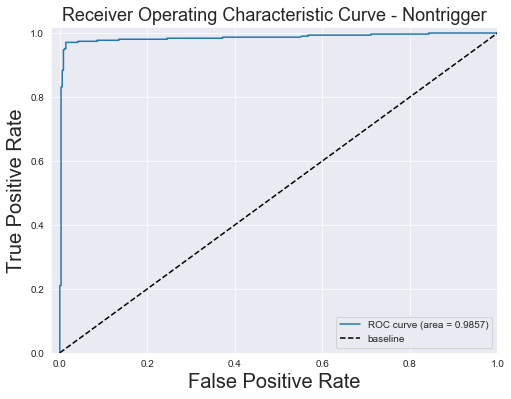

In [102]:
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title(f'Receiver Operating Characteristic Curve - {target.replace("_", " ").title()}', fontsize=18)
plt.legend(loc="lower right");

In [103]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [104]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

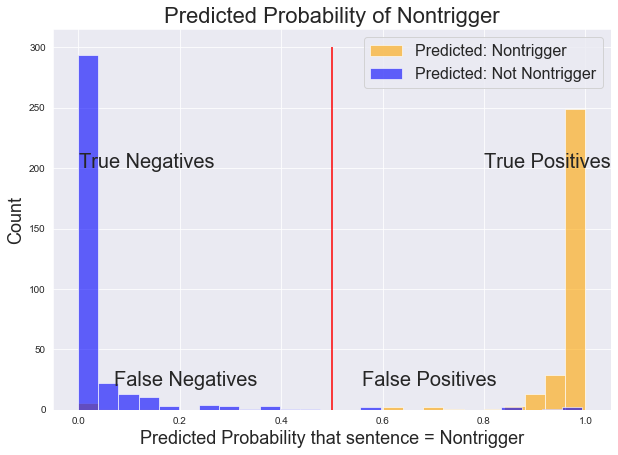

In [105]:
# Histogram overlay for two classes
plt.figure(figsize = (10,7))

# Create two histograms of observations.

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = f'Predicted: {target.replace("_", " ").title()}')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = f'Predicted: Not {target.replace("_", " ").title()}')


plt.vlines(x = .5,
           ymin = 0,
           ymax = 300,
           color = 'r',
           linestyle = '-')


# Label axes.
plt.title(f'Predicted Probability of {target.replace("_", " ").title()}', fontsize = 22)
plt.ylabel('Count', fontsize = 18)
plt.xlabel(f'Predicted Probability that sentence = {target.replace("_", " ").title()}', fontsize = 18)

plt.annotate(xy = (0.001, 200), s = 'True Negatives', size = 20)
plt.annotate(xy = (0.07, 20), s = 'False Negatives', size = 20)
plt.annotate(xy = (0.56, 20), s = 'False Positives', size = 20)
plt.annotate(xy = (0.8, 200), s = 'True Positives', size = 20)

# Create legend.
plt.legend(fontsize = 16);

In [106]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
990,1,1,the related loan documents require the borrower to direct nonresidential tenant to pay rent directly to and the borrowers be require to because all other money receive by the borrowers or the property manager with respect to the properties other than tenant security deposit require to be hold in escrow account to be deposit directly in a lockbox account establish and maintain by the borrowers for the benefit of the lender as the secured party by the end of the first business day follow receipt of such amount
1605,1,1,all interest in the required renovation reserve fund will be add to and become part thereof and disburse therefrom in accordance with the mortgage loan documents
1646,1,1,the borrower establish a lockbox account the lockbox account and the borrower have enter into the cash management agreement for the establishment of a cash management account the cash management account
1660,1,1,at any time the mortgaged property be subject to the management agreement or any approved replacement management agreement the borrower be require to and be require to because the property manager or an approved replacement manager to deposit all amount to be pay to the borrower under the management agreement or an approved replacement management agreement into the lockbox account
1096,1,1,the borrower be require to because all credit card receivables to be remit directly into the lockbox accounts and because all cash revenue relate to the properties and all other money receive by the borrowers or approved property manager with respect to the properties other than tenant security deposit require to be hold in escrow account to be deposit in the lockbox account or the cash management account by the end of the second business day follow receipt by the borrowers or approved property manager


In [107]:
misclassified = results[results['prediction'] != results['actual']]


In [108]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [109]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]

In [110]:
misclassified.head()

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
662,1,0,required renovation cure mean the date on which the fund on deposit in the required renovation reserve account and the replacement reserve account to the extent such fund the property manager have confirm be available and permit to be use for the payment of cost relate to the required renovation work in the aggregate be equal to or great than 90 of the estimate cost to substantially complete the required renovation work as determine base on an officer s certificate of the borrower for purpose of the foregoing any determination make during the first 12 month of the mortgage loan will assume that any amount schedule to be deposit into the required renovation reserve account and the replacement reserve account during such 12 month period have be make provide that the foregoing amount can not be inconsistent with then in place approved annual budget,20190220_02IPLU_Prospectus_SD000000002587491183.pdf,"ÒRequired Renovation CureÓ means the date on which the funds on deposit in the Required Renovation Reserve Account and the Replacement Reserve Account, to the extent such funds the Property Manager has confirmed are available and permitted to be used for the payment of costs related to the Required Renovation Work, in the aggregate, are equal to or greater than 90% of the estimated cost to substantially complete the Required Renovation Work, as determined based on an officerÕs certificate of the Borrower. For purposes of the foregoing, any determination made during the first 12 months of the Mortgage Loan will assume that any amounts scheduled to be deposited into the Required Renovation Reserve Account and the Replacement Reserve Account during such 12-month period have been made, provided that the foregoing amounts cannot be inconsistent with then in-place Approved Annual Budget.",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
689,1,0,priority payment cessation event mean a the conclusion of judicial or non judicial foreclosure proceeding relate to all or a material portion of the property so long as no bankruptcy action of the borrower or the principal have occur and b the satisfaction or other termination of the mortgage loan,20190220_02IPLU_Prospectus_SD000000002587491183.pdf,"ÒPriority Payment Cessation EventÓ means (a) the conclusion of judicial or non-judicial foreclosure proceedings relating to all or a material portion of the Property, so long as no bankruptcy action of the Borrower or the Principal has occurred and (b) the satisfaction or other termination of the Mortgage Loan.",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2113,1,0,the follow item be also require to be deposit into a sub account of the deposit account the rollover account and hold as the rollover funds i other than any lease sweep lease termination payments and any contraction payment which will be deposit into the contraction space account all sum pay with respect to lease modification of any lease or otherwise pay in connection with the borrower take any action under any lease e g grant a consent or waive any provision thereof settlement of claim of the borrower against third party in connection with any lease any termination payment and any sum receive from a tenant to obtain a consent to assignment sublease or holdover or any security deposit hold by the borrower follow a default under a lease and ii any other extraordinary event pursuant to which the borrower receive payment derive from the use ownership or operation of the mortgaged property,20190730_02K9ID_Prospectus_SD000000002678240099.pdf,"The following items are also required to be deposited into a sub-account of the Deposit Account (the ÒRollover AccountÓ) and held as the ÒRollover FundsÓ: (i) other than any Lease Swe

In [111]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [112]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

We incorrectly predicted the trigger type for 16 sentences.


In [113]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

0    9
1    7
Name: prediction, dtype: int64

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [114]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
662,1,0,required renovation cure mean the date on which the fund on deposit in the required renovation reserve account and the replacement reserve account to the extent such fund the property manager have confirm be available and permit to be use for the payment of cost relate to the required renovation work in the aggregate be equal to or great than 90 of the estimate cost to substantially complete the required renovation work as determine base on an officer s certificate of the borrower for purpose of the foregoing any determination make during the first 12 month of the mortgage loan will assume that any amount schedule to be deposit into the required renovation reserve account and the replacement reserve account during such 12 month period have be make provide that the foregoing amount can not be inconsistent with then in place approved annual budget,20190220_02IPLU_Prospectus_SD000000002587491183.pdf,"ÒRequired Renovation CureÓ means the date on which the funds on deposit in the Required Renovation Reserve Account and the Replacement Reserve Account, to the extent such funds the Property Manager has confirmed are available and permitted to be used for the payment of costs related to the Required Renovation Work, in the aggregate, are equal to or greater than 90% of the estimated cost to substantially complete the Required Renovation Work, as determined based on an officerÕs certificate of the Borrower. For purposes of the foregoing, any determination made during the first 12 months of the Mortgage Loan will assume that any amounts scheduled to be deposited into the Required Renovation Reserve Account and the Replacement Reserve Account during such 12-month period have been made, provided that the foregoing amounts cannot be inconsistent with then in-place Approved Annual Budget.",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
689,1,0,priority payment cessation event mean a the conclusion of judicial or non judicial foreclosure proceeding relate to all or a material portion of the property so long as no bankruptcy action of the borrower or the principal have occur and b the satisfaction or other termination of the mortgage loan,20190220_02IPLU_Prospectus_SD000000002587491183.pdf,"ÒPriority Payment Cessation EventÓ means (a) the conclusion of judicial or non-judicial foreclosure proceedings relating to all or a material portion of the Property, so long as no bankruptcy action of the Borrower or the Principal has occurred and (b) the satisfaction or other termination of the Mortgage Loan.",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2113,1,0,the follow item be also require to be deposit into a sub account of the deposit account the rollover account and hold as the rollover funds i other than any lease sweep lease termination payments and any contraction payment which will be deposit into the contraction space account all sum pay with respect to lease modification of any lease or otherwise pay in connection with the borrower take any action under any lease e g grant a consent or waive any provision thereof settlement of claim of the borrower against third party in connection with any lease any termination payment and any sum receive from a tenant to obtain a consent to assignment sublease or holdover or any security deposit hold by the borrower follow a default under a lease and ii any other extraordinary event pursuant to which the borrower receive payment derive from the use ownership or operation of the mortgaged property,20190730_02K9ID_Prospectus_SD000000002678240099.pdf,"The following items are also required to be deposited into a sub-account of the Deposit Account (the ÒRollover AccountÓ) and held as the ÒRollover FundsÓ: (i) other than any Lease Swe

In [115]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [116]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

7 sentences were predicted to be the trigger category, but in fact were not this category.


In [117]:
misclassified_as_true_summary.loc['sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [118]:
misclassified_as_true_summary

,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
662,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
689,1.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2113,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1779,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2194,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2008,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1860,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
sum,7.0,0.0,1,0,0,0,1,0,0,1,0,0,1,0,2,0,1


### Misclassifications: wrongly predicted NOT to be the trigger category

In [119]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
953,0,1,the deposit bank will transfer on each business day during a cash management period fund on deposit in the deposit account to the cash management account which fund be to be apply as set forth in cash management account in this offering circular otherwise such fund will be remit to the borrower,20170616_02DNAM_Prospectus_SD000000002355931744.pdf,"The Deposit Bank will transfer on each Business Day during a Cash Management Period funds on deposit in the Deposit Account to the Cash Management Account, which funds are to be applied as set forth in ÒÑCash Management AccountÓ in this Offering Circular, otherwise such funds will be remitted to the Borrower.",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
980,0,1,in the event the lender draw on any letter of credit deliver as cash sweep avoidance collateral in accordance with the term of the mortgage loan agreement the proceed thereof be require to be deposit into the cash sweep avoidance collateral reserve account,20170616_02DNAM_Prospectus_SD000000002355931744.pdf,"In the event the Lender draws on any letter of credit delivered as Cash Sweep Avoidance Collateral in accordance with the terms of the Mortgage Loan Agreement, the proceeds thereof are required to be deposited into the Cash Sweep Avoidance Collateral Reserve Account.",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1494,0,1,the mortgage lender be require to disburse to the borrower the immediate repair funds upon satisfaction by borrower of each of the following condition i borrower submit a request for payment to mortgage lender at least 10 day prior to the date on which borrower request such payment be make and specifie the immediate repairs to be pay ii on the date such request be receive by mortgage lender and on the date such payment be to be make no mortgage loan event of default exist iii mortgage lender have receive a certificate from borrower a state that all immediate repairs to be fund by the request disbursement have be complete in a good and workmanlike manner and in accordance with all applicable legal requirements such certificate to be accompany by a copy of any license permit or other approval by any governmental authority require in connection with the immediate repairs b identify each person that supply material or labor in connection with the immediate repairs to be fund by the request disbursement and c state that each such person have be pay in full or will be pay in full upon such disbursement such certificate to be accompany by lien waiver invoice and or other evidence of payment reasonably satisfactory to mortgage lender iv at mortgage lender s option if the cost of the immediate repairs exceed 50 000 a title search for the applicable property indicate that the applicable property be free from all lien claim and other encumbrance other than permit encumbrances v at mortgage lender s option if the cost of the immediate repairs exceed 50 000 mortgage lender receive a report satisfactory to mortgage lender in PRON reasonable discretion from an architect or engineer approve by mortgage lender such approval not to be unreasonably withhold or delay in respect of such architect or engineer s inspection of the require repair and vi mortgage lender receive such other evidence as mortgage lender reasonably request that the immediate repairs to be fund by the request disbursement have be complete and be pay for or will be pay upon such disbursement to borrower,20190205_02IJ77_Prospectus_SD000000002579874729.pdf,"The Mortgage Lender is required to disburse to the Borrower the Immediate Repair Funds upon satisfaction by Borrower of each of the following conditions: (i) Borrower submits a request for payment to Mortgage Lender at least 

In [120]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [121]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

9 sentences were predicted not to be the trigger category, but in fact were this trigger category.


In [122]:
misclassified_as_false_summary.loc['sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
953,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
980,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1494,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1347,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
828,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
913,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
979,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1538,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1693,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Export Misclassification summaries

In [123]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_false_06_15_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_true_06_15_20.csv')

In [124]:
# Export to CSV fie
#misclassified_as_false.to_csv(f'../data/exported_data/{target}_misclassified_as_false_sentences_06_15_20.csv')
#misclassified_as_true.to_csv(f'../data/exported_data/{target}_misclassified_as_true_sentences_06_15_20.csv')